In [ ]:
%matplotlib inline
import lib.plots.stan
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.violinplot(pstr_samples_1['x0'][150:]);
plt.axhline(-2.0,color='red')
xtick_labels = []
for i in range(84):
    if(i%2 == 0):
        xtick_labels.append(str(i+1))
    else:
        xtick_labels.append('')
plt.xticks(np.r_[1:85],xtick_labels);
plt.xlabel('Region#',fontsize=15);
plt.ylabel('$x_0$',fontsize=15);

import lib.plots.stan

lib.plots.stan.nuts_diagnostics(pstr_samples_1)

In [ ]:
ez = [59]
pz = [74, 82]
plt.figure(figsize=(15,10))
ax_src_x = plt.subplot(211)
ax_src_z = plt.subplot(212)
sample_idx = -1
for i in range(84):
    if i in ez: 
        ax_src_x.plot(pstr_samples_1['x'][sample_idx,:,i], color='red');
        ax_src_z.plot(pstr_samples_1['z'][sample_idx,:,i], color='red');
    elif i in pz:
        ax_src_x.plot(pstr_samples_1['x'][sample_idx,:,i], color='orange');
        ax_src_z.plot(pstr_samples_1['z'][sample_idx,:,i], color='orange');
    else:
        ax_src_x.plot(pstr_samples_1['x'][sample_idx,:,i], color='black', alpha=0.1);
        ax_src_z.plot(pstr_samples_1['z'][sample_idx,:,i], color='black', alpha=0.1);
ax_src_x.set_title("Source activity - x")
ax_src_z.set_title("Source activity - z")

Phase space plots

In [ ]:
for i in range(84):
    if i in ez: 
        plt.plot(pstr_samples_1['x'][-1,:,i], pstr_samples_1['z'][-1,:,i], color='red')
    elif i in pz:
        plt.plot(pstr_samples_1['x'][-1,:,i], pstr_samples_1['z'][-1,:,i], color='orange')
    else:
        plt.plot(pstr_samples_1['x'][-1,:,i], pstr_samples_1['z'][-1,:,i], color='black')

Downsampling **seeg log power**

In [ ]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# fit_trgt = np.load('datasets/id001_ac/AC_fit_trgt.npz')['fit_trgt']
# fit_trgt_ds = fit_trgt[0:-1:20,:]
# plt.figure(figsize=(15,5))
# plt.plot(fit_trgt,alpha=0.3);
# plt.xlabel('time')
# plt.ylabel('slp')
# plt.title('Original')
# plt.figure(figsize=(15,5))
# plt.plot(fit_trgt_ds,alpha=0.3);
# plt.xlabel('time')
# plt.ylabel('slp')
# plt.title('Downsampled')

syn_data = np.load('datasets/id001_ac/AC_syn_tvb_ez=59_pz=82-74.npz')
srcSig = syn_data['src_sig'][2200:3800:20,0,:,0] + syn_data['src_sig'][2200:3800:20,3,:,0]
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(srcSig);

Testing centered SDE model

In [1]:
%reset -f
%matplotlib inline
import numpy as np
import lib.io.stan
import matplotlib.pyplot as plt
import os

In [2]:
data_dir = 'datasets/id001_ac'
results_dir = 'tmp'
fit_data_dir = f'{results_dir}/Rfiles' #'jureca/data'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/AC_network.npz')
SC = network['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

mdld_data = np.load(f'{data_dir}/AC_fit_trgt.npz')['fit_trgt']
mdld_data_ds = mdld_data[0:-1:20,:]

In [3]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = mdld_data_ds.shape[0]
I1 = 3.1
tau0 = 2857.0
epsilon = 0.1

stan_fname = 'vep-snsrfit-cntr'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)

# x0_star = np.zeros(nn)
# x_init = -2.0*np.ones(nn)
# z_init = 3.5*np.ones(nn)
# amplitude = 0.1*np.ones(ns)
# offset = 180*np.ones(ns)
# epsilon = 0.01

# param_init = {'x0_star':x0_star, 'x_init':x_init, 'z_init':z_init, 'amplitude':amplitude,
#                 'offset':offset, 'epsilon':0.1}
# param_init_file = 'param_init.R'
# lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

# for sigma in np.arange(0.01, 0.51, 0.01):
#     for epsilon in np.arange(0.01, 0.51, 0.01):
#         data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'SC':SC, 
#                 'K':K, 'gain': gain_mat, 'sigma':sigma, 'epsilon':epsilon, 'slp':mdld_data_ds}
#         input_Rfile = f'fit_data_sigma{sigma:0.2f}_eps{epsilon:0.2f}.R'
#         os.makedirs(fit_data_dir,exist_ok=True)
#         lib.io.stan.rdump(f'{fit_data_dir}/{input_Rfile}',data)
#     #     nchains = 4
#     #     with open('vep-snsrfit-cntr.sh','r') as fd:
#     #         slurm_script = fd.read().format(f'{results_dir}/Rfiles', results_dir, input_Rfile, nchains, eps)
#     #     with open(f'tmp/vep-snsrfit-cntr-sigma{sigma:0.5f}.sh','w') as fd:
#     #         fd.write(slurm_script)
#     #     lib.io.stan.create_process(['sbatch',f'tmp/vep-snsrfit-ode-sigma{sigma:0.5f}_eps{epsilon:0.5f}.sh'],block=False)
    
sigma = 0.1
data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'gain':gain_mat, 'SC':SC, \
        'K':K, 'sigma':sigma, 'epsilon':epsilon, 'slp':mdld_data_ds}
input_Rfile = f'fit_data_sigma{sigma:0.2f}_eps{epsilon:0.2f}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}', data)

# cmd = f'./vep-snsrfit-cntr variational iter=1000000 tol_rel_obj=0.0001 output_samples=1000 data \
# file={results_dir}/Rfiles/{input_Rfile} \
# output file={results_dir}/samples_sigma{sigma:0.2f}_eps{epsilon:0.2f}.csv refresh=10'
# print(cmd.split(' '))
# lib.io.stan.create_process(cmd.split(' '), block=True)

/home/anirudhnihalani/vep.stan
make: `/home/anirudhnihalani/vep.stan/vep-snsrfit-cntr' is up to date.


In [ ]:
# %%bash -s "$results_dir" "$input_Rfile" "$sigma" "$epsilon"
# srun -p rhu -t 24:00:00 ./vep-snsrfit-cntr variational iter=1000000 tol_rel_obj=0.01 \
# output_samples=1000 data file=${1}/Rfiles/${2} \
# output file=${1}/samples_sigma${3}_eps${4}.csv &> ${1}/logs/snsrfit_cntr_sigma${3}_epsilon${4}.log

In [4]:
%%bash -s "$results_dir" "$input_Rfile" "$sigma" "$epsilon"
for i in {1..4};
do
srun -p rhu -t 24:00:00 ./vep-snsrfit-cntr sample save_warmup=1 num_warmup=500 num_samples=500 adapt delta=0.8 algorithm=hmc engine=nuts \
max_depth=10 data file=${1}/Rfiles/${2} \
output file=${1}/samples_sigma${3}_eps${4}_chain${i}.csv \
&> ${1}/logs/snsrfit_cntr_sigma${3}_epsilon${4}_chain${i}.log &
done

In [ ]:
# import lib.io.stan
import importlib
importlib.reload(lib.io.stan)

csv_fname = 'results/exp10/exp10.7/exp10.7.3/samples_sigma0.01_eps0.01.csv'
# nwarmup = 200
# nsampling = 200
variables_of_interest = ['lp__','accept_stat__','stepsize__','treedepth__','n_leapfrog__',\
                         'divergent__', 'energy__','x0',  'x', 'z', 'amplitude', 'offset',\
                         'x_init', 'z_init', 'time_step']
pstr_samples_1 = lib.io.stan.read_samples(csv_fname) # read sampler diagnostics and x0 for all sampling iterations

# csv_fname = 'results/exp10/exp10.4/samples_eps0.1_chain1.csv'
# nwarmup = 1000
# nsampling = 1000
# ignore_warmup = True
# variables_of_interest = ['x','z']
# pstr_samples_2 = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup,variables_of_interest) # read 10 samples of hidden state variables x and z

In [ ]:
%matplotlib inline
import lib.plots.stan
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.violinplot(pstr_samples_1['x0']);
plt.axhline(-2.0,color='red')
xtick_labels = []
for i in range(84):
    if(i%2 == 0):
        xtick_labels.append(str(i+1))
    else:
        xtick_labels.append('')
plt.xticks(np.r_[1:85],xtick_labels);
plt.xlabel('Region#',fontsize=15);
plt.ylabel('$x_0$',fontsize=15);

# lib.plots.stan.nuts_diagnostics(pstr_samples_1)

# # Mean and 2*std of source activity(x) estimated from posterior samples
# plt.figure(figsize=(15,20))
# x_mean = np.mean(pstr_samples_1['x'], axis = 0)
# x_std = np.std(pstr_samples_1['x'], axis = 0)
# nt = x_mean.shape[0]
# nn = x_mean.shape[1]
# for i in range(nn):
#     plt.plot(x_mean[:,i]+4*i)
#     plt.fill_between(np.r_[0:nt], x_mean[:,i] - 2*x_std[:,i] + 4*i, x_mean[:,i] + 2*x_std[:,i] + 4*i,alpha=0.1)
# plt.title('source activity(x)',fontsize=15);
# plt.xlabel('time',fontsize=15);
# plt.ylabel('Region#',fontsize=15);
# plt.yticks(np.mean(x_mean,axis=0) + 4*np.r_[0:nn], np.r_[1:nn+1]);

In [ ]:
ntwrk = np.load('datasets/id001_ac/AC_network.npz')
gain = ntwrk['gain_mat']
src_sig = pstr_samples_1['x']
amplitude = pstr_samples_1['amplitude']
offset = pstr_samples_1['offset']
slp = np.zeros([src_sig.shape[0],src_sig.shape[1],gain.shape[0]])
for i,sample in enumerate(src_sig):
#     seeg[i] = amplitude[i,:] * ((gain @ sample.T).T + offset[i,:]);
    slp[i] = amplitude[i] * (np.log(gain @ np.exp(sample).T).T + offset[i])
    
mdld_data = np.load('datasets/id001_ac/AC_fit_trgt.npz')
plt.figure(figsize=(15,4))
plt.plot(mdld_data_ds,'k',alpha=0.4);
plt.plot(slp[-1],'r', alpha=0.4);

In [ ]:
ez = [59]
pz = [74, 82]
plt.figure(figsize=(15,10))
ax_src_x = plt.subplot(211)
ax_src_z = plt.subplot(212)
sample_idx = -1
for i in range(84):
    if i in ez: 
        ax_src_x.plot(pstr_samples_1['x'][sample_idx,:,i], color='red');
        ax_src_z.plot(pstr_samples_1['z'][sample_idx,:,i], color='red');
    elif i in pz:
        ax_src_x.plot(pstr_samples_1['x'][sample_idx,:,i], color='orange');
        ax_src_z.plot(pstr_samples_1['z'][sample_idx,:,i], color='orange');
    else:
        ax_src_x.plot(pstr_samples_1['x'][sample_idx,:,i], color='black', alpha=0.1);
        ax_src_z.plot(pstr_samples_1['z'][sample_idx,:,i], color='black', alpha=0.1);
ax_src_x.set_title("Source activity - x")
ax_src_z.set_title("Source activity - z")

plt.figure()
for i in range(84):
    if i in ez: 
        plt.plot(pstr_samples_1['x'][-1,:,i], pstr_samples_1['z'][-1,:,i], color='red')
    elif i in pz:
        plt.plot(pstr_samples_1['x'][-1,:,i], pstr_samples_1['z'][-1,:,i], color='orange')
#     else:
#         plt.plot(pstr_samples_1['x'][-1,:,i], pstr_samples_1['z'][-1,:,i], color='black')
plt.xlabel('x', fontsize=12.0)
plt.ylabel('z', fontsize=12.0)
plt.title('Phase Space')

In [ ]:
plt.figure(figsize=(13,4))
plt.subplot(131)
plt.hist(pstr_samples_1['amplitude'][50:].flatten())
plt.title('Amplitude')
plt.subplot(132)
plt.hist(pstr_samples_1['offset'][50:].flatten())
plt.title('Offset')
plt.subplot(133)
plt.plot(pstr_samples_1['time_step'][50:])
plt.title('time_step')


Testing forward simulation code in STAN

In [134]:
%reset -f
import lib.io.stan
import matplotlib.pyplot as plt
import numpy as np

In [135]:
data_dir = 'datasets/id001_ac'
results_dir = 'tmp'
fit_data_dir = f'{results_dir}/Rfiles' #'jureca/data'

network = np.load(f'{data_dir}/AC_network.npz')
SC = network['SC']
K = np.max(SC)
SC = SC / K
K = 0.001069
SC[np.diag_indices(SC.shape[0])] = 0
gain = network['gain_mat']
syn_data = np.load(f'{data_dir}/AC_syn_tvb_ez=59_pz=82-74.npz')

nn = SC.shape[0]
ns = gain.shape[0]
nt = 1600
I1 = 3.1
tau0 = 0.032


# x0 = syn_data['x0']
x0 = np.array([-2.0122769 , -1.947755  , -2.1732031 , -2.01035659, -2.30977504,
       -2.28947492, -2.42664569, -2.17562788, -2.33529297, -2.26797662,
       -0.3621214 , -2.26653747, -2.66458976, -1.84212309, -1.94948215,
       -1.68984695, -2.16886772, -2.13137383, -2.26459527, -1.69957936,
       -2.32034828, -2.30905212, -2.53942727, -2.53270543, -2.78243607,
       -0.41212241, -1.08744546, -2.23832902, -2.03499248, -2.45454551,
       -2.30441941,  0.00316994, -1.90427512, -2.08376862, -2.2132924 ,
       -2.37413304, -2.31119161, -0.48542592, -1.89236011, -2.48524823,
       -1.78543555, -2.21336683, -2.08356882, -2.9063244 , -2.43741756,
       -2.39480823, -2.09243982, -2.1529682 , -1.64679456, -2.0019525 ,
       -0.96455956, -0.71775421, -1.96349711, -1.01936081, -0.44220669,
       -2.19362123, -0.70359318, -2.1350832 , -2.45456609,  2.57629057,
       -1.95198817, -0.40557476,  1.01013205,  0.00958962, -2.41625614,
       -1.48590308, -3.131939  , -2.51707634, -2.09240827, -2.10501854,
       -2.26716608, -1.03879132, -2.44880238, -2.90785374,  1.28230306,
       -0.39339373, -2.46675502, -2.24430329, -2.2497985 , -2.28754136,
       -0.39741313, -1.7691787 ,  0.42884056, -2.63486512])
x_init = -3*np.ones(nn)
z_init = 3.2*np.ones(nn)
time_step = 0.0065


data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'gain':gain, 'SC':SC, \
        'K':K, 'x0':x0, 'x_init':x_init, 'z_init':z_init, 'time_step':time_step}
lib.io.stan.rdump(f'tmp/Rfiles/test.R', data)

In [94]:
print(syn_data.keys())
print(syn_data['src_sig'].shape)
print(syn_data['seeg'].shape)

['Ks', 'src_sig', 'pz_x0', 'time_steps', 'seeg', 'ez', 'pz_kplng', 'x0']
(10000, 7, 84, 1)
(70, 10000)


In [136]:
%%bash
stancompile.sh test

/home/anirudh/Academia/projects/vep.stan
make: '/home/anirudh/Academia/projects/vep.stan/test' is up to date.


In [137]:
%%bash
./test sample num_warmup=0 num_samples=1 algorithm=fixed_param data file='tmp/Rfiles/test.R' output file='tmp/test.csv'

method = sample (Default)
  sample
    num_samples = 1
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = fixed_param
id = 0 (Default)
data
  file = tmp/Rfiles/test.R
init = 2 (Default)
random
  seed = 2502825937
output
  file = tmp/test.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.170145 seconds (Sampling)
               0.170145 seconds (Total)



In [138]:
sim_data = lib.io.stan.read_samples('tmp/test.csv')
fit_data = np.load(f'{data_dir}/AC_fit_trgt.npz')
x_syn = syn_data['src_sig'][2200:3800,0,:,0] + syn_data['src_sig'][2200:3800,3,:,0]
ez = syn_data['ez']
pz = np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

Text(0.5,1,'synthetic data')

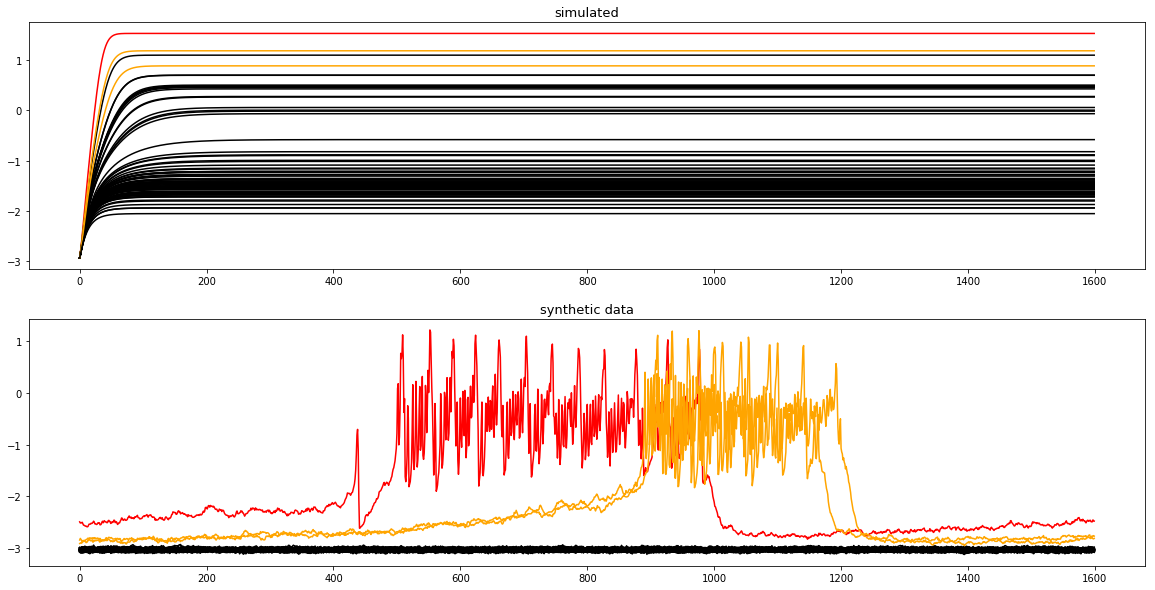

In [139]:
x_sim = sim_data['x'][0,:,:]
z_sim = sim_data['z'][0,:,:]
plt.figure(figsize=(20,10))
plt.subplot(211)
for i in range(nn):
    if(i in ez):
        plt.plot(x_sim[:,i], color='red');
    elif(i in pz):
        plt.plot(x_sim[:,i], color='orange');
    else:
        plt.plot(x_sim[:,i], color='black');
plt.title('simulated', fontsize=13)


# plt.yticks(4*np.r_[0:84],np.r_[0:84]);
plt.subplot(212)
for i in range(nn):
    if(i in ez):
        plt.plot(x_syn[:,i], color='red');
    elif(i in pz):
        plt.plot(x_syn[:,i], color='orange');
    else:
        plt.plot(x_syn[:,i], color='black');
plt.title('synthetic data', fontsize=13)

# plt.plot(z + 4*np.r_[0:84]);
# plt.yticks(4*np.r_[0:84],np.r_[0:84]);

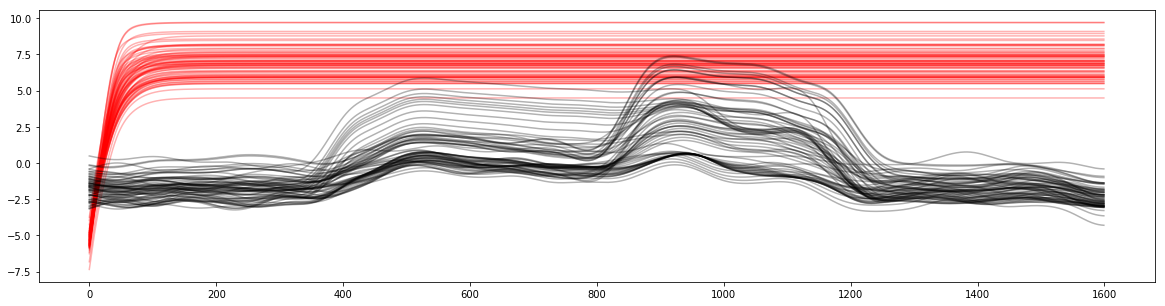

In [140]:
amp = 4.0
offset = -3
slp = amp * (np.log(gain@np.exp(x_sim.T)).T + offset)
plt.figure(figsize=(20,5))
plt.plot(slp, color='red', alpha=0.3);


plt.plot(fit_data['fit_trgt'], color='black', alpha=0.3);

Testing variational inference with $K$ and $\tau_0$ inferred